In [46]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.model import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

### Generates Empirical Data

Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [5]:
ps = load_obj('../models/peak_sampler_4_beers.p')

Creates a liquid chromatography column, with 3 `KnownChemical`.

In [6]:
# need vinny to fix
# formula_strings = ['C8H10N4O2', 'C6H9N3O2', 'C5H9NO2']
# column = KnownColumn('LC', formula_strings, ps)

Creates a liquid chromatography column, with 10 `UnknownChemical`.

In [98]:
xcms_output = '../models/beer_ms1_peaks.csv.gz'
num_chemicals = 1000
column = UnknownColumn('LC', num_chemicals, ps, xcms_output)

Loading observed chromatograms
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


Plot some chemicals

UnknownChemical mz=140.4710 rt=680.57 max_intensity=1.00


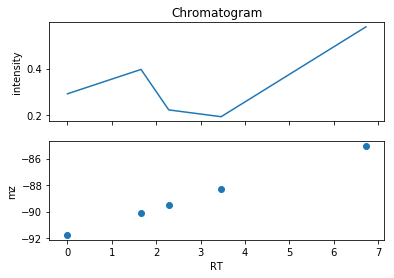

UnknownChemical mz=373.2768 rt=429.91 max_intensity=1.00


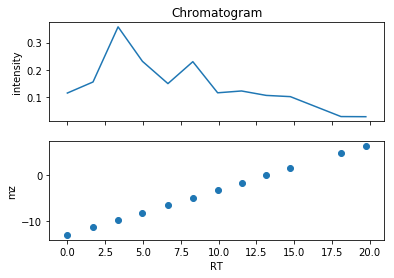

UnknownChemical mz=105.2417 rt=1133.55 max_intensity=1.00


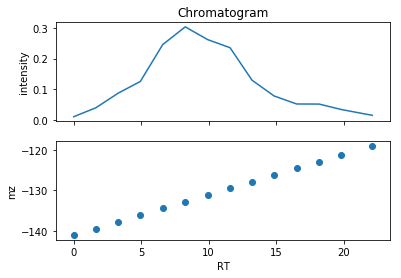

In [99]:
def plot_chromatogram(chrom):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(chrom.rts, chrom.intensities)
    axarr[0].set_title('Chromatogram')
    axarr[0].set_ylabel('intensity')
    axarr[1].scatter(chrom.rts, chrom.mzs)
    axarr[1].set_ylabel('mz')
    axarr[1].set_xlabel('RT')    
    plt.show()

for chem in column.chemicals[0:3]:
    print(chem)
    plot_chromatogram(chem.chromatogram)

Connect the column to mass spec. Define the scan times, scan_levels and isolation windows.

In [100]:
scan_times = np.arange(0, 1000)+1
scan_levels = np.zeros_like(scan_intervals)
scan_levels.fill(1)
isolation_windows = [[(0, 1e3)]]

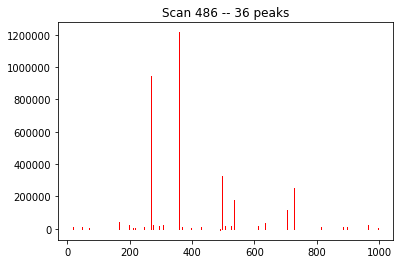

19.755963727106078 11313.92369306044
46.71480982071225 8197.787200725124
70.5151588232365 2932.1726087796296
166.0051984219482 40526.893217183904
196.61333058517428 21908.89502012412
212.2733409546628 2618.572066420827
217.76771512087657 6001.730374017411
245.66754786539602 11209.315531767495
258.71453485697907 815.6668904425691
268.82656034595385 942089.5019200458
275.03086012785883 665.8205507029554
275.8766200904968 23339.6004308172
293.3979531039825 14705.741800677743
307.86220216974215 22980.6134924037
357.22424095969393 1215297.453369088
368.891206036955 11012.200071404257
397.7809888875805 5275.988385820616
398.63341959311515 737.0806671999869
427.9368945127536 8032.552026786369
490.51064358211386 -7667.301577427699
496.62670089234246 323050.7759691883
505.28297432752333 17890.384728672427
524.7433645795088 19166.853746579724
533.4547272399717 175422.5211541326
612.3011785153581 18325.681440950528
612.4587874946453 7252.128995156088
634.7115386887501 36791.975128203536
705.16774

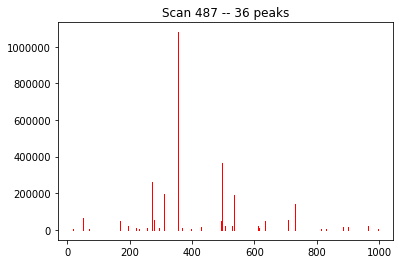

18.755963727106078 6007.514674588987
48.894809820712254 65557.8309425763
69.5151588232365 2510.357285543437
168.1591984219482 45433.093792633656
195.61333058517428 21774.21162525754
220.02971512087652 10146.046594913441
230.77734095466272 4581.822494841309
254.56954786539595 7211.084436890809
257.71453485697907 -906.0532013696923
271.06656034595386 260714.05976378423
274.03086012785883 603.3784483417744
278.13662009049676 52844.69745724802
292.3979531039825 10777.564371562463
309.90620216974224 197612.23103145545
356.22424095969393 1078904.8889897792
367.891206036955 10475.454859978141
396.7809888875805 4656.77196855584
397.63341959311515 720.5265967439417
430.20889451275355 12466.633078284593
492.7726435821138 45543.6791726669
495.62670089234246 366765.5064052233
504.28297432752333 20563.148029528544
526.9693645795087 20088.328642377986
535.7007272399716 192455.22848585172
611.3011785153581 18244.971792069864
614.2087874946453 10705.919493703539
633.7115386887501 49178.611328673265
70

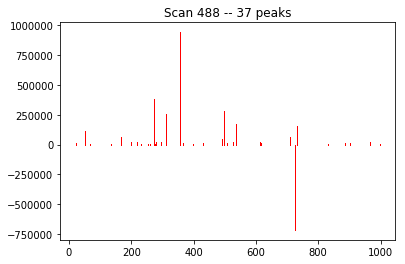

21.167963727106113 10156.551406041595
51.222809820712286 111407.66103979987
68.5151588232365 2088.541962307244
135.4810024218724 1905.5004868025128
167.1591984219482 65968.06903714452
197.9193305851742 23430.13224695858
217.6589165568853 25173.98480518853
219.02971512087652 11541.510184606443
229.77734095466272 4245.2194926323455
253.56954786539595 7021.712001946939
260.1065348569791 4404.010570857983
273.3425603459538 379520.28173972096
276.2548601278589 877.6443041211135
280.3986200904967 22288.555769760504
294.70795310398245 17824.675256682393
311.84420216974235 260448.50838100901
355.22424095969393 942512.32461047
366.891206036955 9938.709648552025
396.63341959311526 703.9725262878965
398.81898888758053 6834.282659522151
429.20889451275355 10548.583427825899
491.7726435821138 49309.29494375677
497.9087008923424 283671.50901984266
506.6649743275234 12507.425519710274
525.9693645795087 23087.510161709917
534.7007272399716 171534.56998710163
613.4831785153582 17582.211985107402
615.00

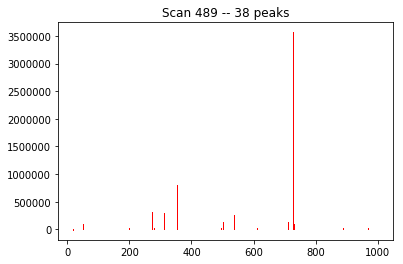

20.167963727106113 -10339.99231623497
50.222809820712286 90494.95223057597
74.09715882323655 3270.7979703091746
136.5630024218724 1227.2394889371808
169.4231984219482 3114.976326417168
200.19533058517428 19207.234762902594
216.6589165568853 7292.9735303358675
221.28171512087647 5786.591422508192
232.04534095466275 5412.43137708318
252.56954786539595 6832.3395670030695
259.1065348569791 5121.298664900111
272.3425603459538 321264.2288957422
278.5368601278589 586.694651211145
279.3986200904967 23701.706060839817
293.70795310398245 9902.034945341016
310.84420216974235 290165.9484777433
354.22424095969393 806119.760231161
365.891206036955 9401.964437125913
395.63341959311526 687.4184558318514
401.0049888875807 5897.481232096354
431.4988945127536 15242.667220685471
494.03464358211386 25218.735565629595
500.1247008923423 133284.29106430695
505.6649743275234 13109.534765979188
528.0213645795087 14447.079432412389
536.7447272399717 264566.24887351727
612.4831785153582 16183.831565593202
616.106

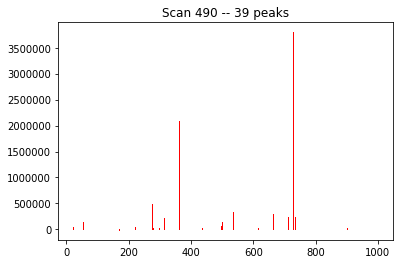

22.473963727106096 45712.12612620684
52.5508098207122 149130.95350261213
73.09715882323655 178.395751006625
137.77300242187238 1794.2546464258282
168.4231984219482 -10140.957533145003
199.19533058517428 16279.75729392706
218.94291655688517 46449.317404437934
223.1997151208766 9607.252602403705
234.30134095466283 4896.647045217926
251.56954786539595 6642.9671320592
261.3785348569792 2478.7417085375
274.69256034595384 498158.8180946773
277.5368601278589 510.594055789602
278.3986200904967 25114.85635191913
296.09595310398237 28071.112237571833
313.10820216974224 222716.79153091626
362.91224095969403 2087826.8113488432
364.891206036955 8865.219225699793
400.0049888875807 6227.429001009992
401.1874195931151 680.8181085867081
433.7728945127536 18579.232291193588
496.2546435821138 60516.7317663041
499.1247008923423 151380.21135817425
504.6649743275234 13711.644012248102
530.2073645795087 16348.999710606124
535.7447272399717 343341.31426365185
614.759178515358 24575.886922672566
616.8547874946

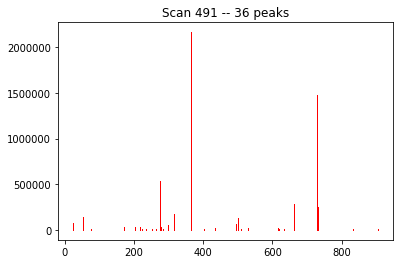

24.76596372710607 71147.27278812412
51.5508098207122 144267.8562036352
75.41315882323653 7749.123165434261
138.0150024218724 2308.7764755868216
170.62719842194815 29094.163506027206
201.39733058517427 27571.161998143765
217.94291655688517 26651.7037145977
222.1997151208766 10002.425194293584
233.30134095466283 5477.3251379706
250.56954786539595 6453.59469711533
263.6565348569791 3584.2942855898614
273.69256034595384 533645.20866721
277.3986200904967 26528.006642998447
279.80286012785876 699.5370537396997
284.67961320797065 5049.7077333600155
298.37195310398243 47829.86645841787
315.1762021697422 167773.15370413617
363.891206036955 8328.474014273681
365.1482409596939 2164702.5277585923
400.1874195931151 542.0915402252901
402.26498888758067 5442.407877541302
432.7728945127536 23002.365838589387
495.2546435821138 63501.04486553675
501.3987008923424 123537.42909973385
510.2169743275234 10760.963387545524
529.2073645795087 16553.111579051358
617.0251785153581 14480.318093169768
617.78278749

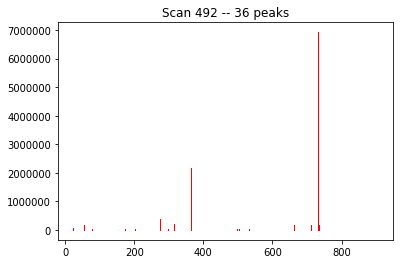

23.76596372710607 61840.61248701258
53.878809820712235 172077.08386878393
77.75715882323658 14648.009206318877
139.4930024218724 1539.365439863987
172.91119842194814 35871.54672001608
203.60933058517426 18256.636231871744
216.94291655688517 6854.090024757477
224.47371512087648 10867.077935061743
235.56934095466286 3854.903518537768
249.56954786539595 6264.22226217146
262.6565348569791 3269.5500978844216
275.9765603459538 378477.18665435025
278.80286012785876 658.1586483031349
282.88262009049663 13911.869980148704
286.88161320797064 10539.481057407365
297.37195310398243 36863.68696975157
314.1762021697422 216363.71573467428
362.891206036955 7791.728802847565
364.1482409596939 2163786.9994336106
399.1874195931151 403.3649718638721
404.5189888875806 4774.09184152692
434.8608945127536 8773.151281511056
497.34264358211385 34895.79337558664
503.6327008923423 38958.24282072601
509.2169743275234 12089.718955825796
531.5313645795087 16759.894560990808
616.0251785153581 14349.807735325101
618.31

In [106]:
def plot_scan(scan):
    plt.figure()
    for i in range(scan.num_peaks):
        x1 = scan.mzs[i]
        x2 = scan.mzs[i]
        y1 = 0
        y2 = scan.intensities[i]
        a=[[x1,y1],[x2,y2]]
        plt.plot(*zip(*a), marker='', color='r', ls='-', lw=1)
    plt.title('Scan {0} -- {1} peaks'.format(scan.scan_id, scan.num_peaks))
    plt.show()    

mass_spec = IndependentMassSpectrometer(column, scan_times, scan_levels, isolation_windows)
for scan in mass_spec:
    if scan.num_peaks > 35:
        plot_scan(scan)
        for mz, intensity in zip(scan.mzs, scan.intensities):
            print(mz, intensity)

### Generates Synthetic data

We want a notebook that does the following:
1. create a list of chemical
2. create a new mass spec object, takes chemicals
3. create a new controller, takes mass spec
4. write mzml files

In [ ]:
# chrom = FunctionalChromatogram("normal", [0,1])
# formula = Formula("hg",100)
# isotopes = Isotopes(formula,[0.8,0.2],["Mono","1C13"])
# aducts = Aducts(formula,["M+H","M+ACN"],[0.9,0.1])
# chem = KnownChemical(formula,isotopes,aducts,100, 10000, chrom, None)
# print(chem.formula)
# print(chem.isotopes)
# print(chem.aducts)